In [1]:
import jax, numpyro
import jax.numpy as jnp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

from jax import random
from numpyro.infer import MCMC, NUTS, Predictive
from numpyro.distributions import (
    Normal, Uniform, TruncatedNormal, Beta, InverseGamma, StudentT, HalfNormal, LogNormal,
    TruncatedDistribution
)
from numpyro.infer.reparam import LocScaleReparam
from corner import corner

from eggman.emulator import Emulator
from eggman.distributions import LogSalpeter
from copy import deepcopy

numpyro.enable_x64()
numpyro.set_platform("cpu")
numpyro.set_host_device_count(10)
rng = random.PRNGKey(0)

In [2]:
from numpyro.handlers import trace, seed, substitute

In [3]:
from eggman.infer import Star

Holoviews not imported. Some visualizations will not be available.
PyMultiNest not imported.  MultiNest fits will not work.


In [4]:
bounds = jnp.arange(0.0, 5.0)
widths = jnp.diff(bounds)
new_bounds = jnp.array([0.0, 0.3, 0.6, 0.7, 1.0])
new_widths = jnp.diff(new_bounds)

def generator(a, b, c):
    return lambda x: a + b * (x - c)

funclist = [generator(l, w/nw, nl) for w, nw, l, nl in zip(widths, new_widths, bounds[:-1], new_bounds[:-1])]
    
def evol_phase(x):
    return jnp.piecewise(
        x,
        [(lower <= x) & (x < upper) for lower, upper in zip(new_bounds[:-1], new_bounds[1:])],
        funclist,
    )

(0.0, 4.0)

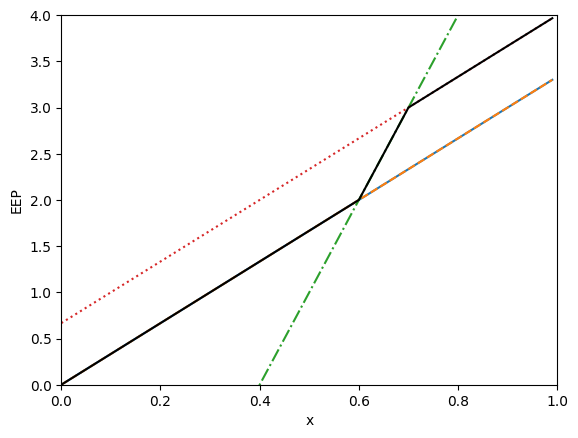

In [5]:
x = np.arange(0, 1, 0.01)

for ls, f in zip(['solid', 'dashed', 'dashdot', 'dotted'], funclist):
    plt.plot(x, f(x), ls=ls)
y = evol_phase(x)

plt.plot(x, y, "k")
plt.xlabel("x")
plt.ylabel("EEP")
plt.xlim(0, 1)
plt.ylim(0, 4)

In [6]:
truths = {
    "x": 0.4,
    "ln_mass": np.log(1.6),
    "Y": 0.28,
    "M_H": 0.0,
    "a_MLT": 2.0,
    "plx": 0.047,
    "Av": 0.01
}

const = {}
const["M_H"] = {"mu": truths["M_H"], "sigma": 0.1}
const["plx"] = {"mu": truths["plx"], "sigma": 2.35e-5}
const["Av"] = {"mu": truths["Av"], "sigma": 0.003}

model = Star()

true_trace = trace(seed(substitute(model, truths), rng)).get_trace(const)
truths = {k: v["value"] for k, v in true_trace.items()}

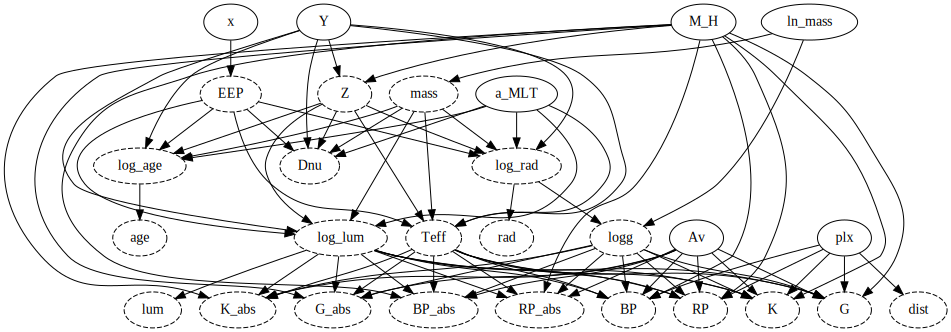

In [7]:
numpyro.render_model(model, model_args=(const,))

In [8]:
rng, key = random.split(rng)
prior_predictive = Predictive(model, num_samples=10000)
prior_samples = prior_predictive(key, const)

In [9]:
data = az.from_numpyro(prior=prior_samples)
data

Inference data with groups:
	> prior

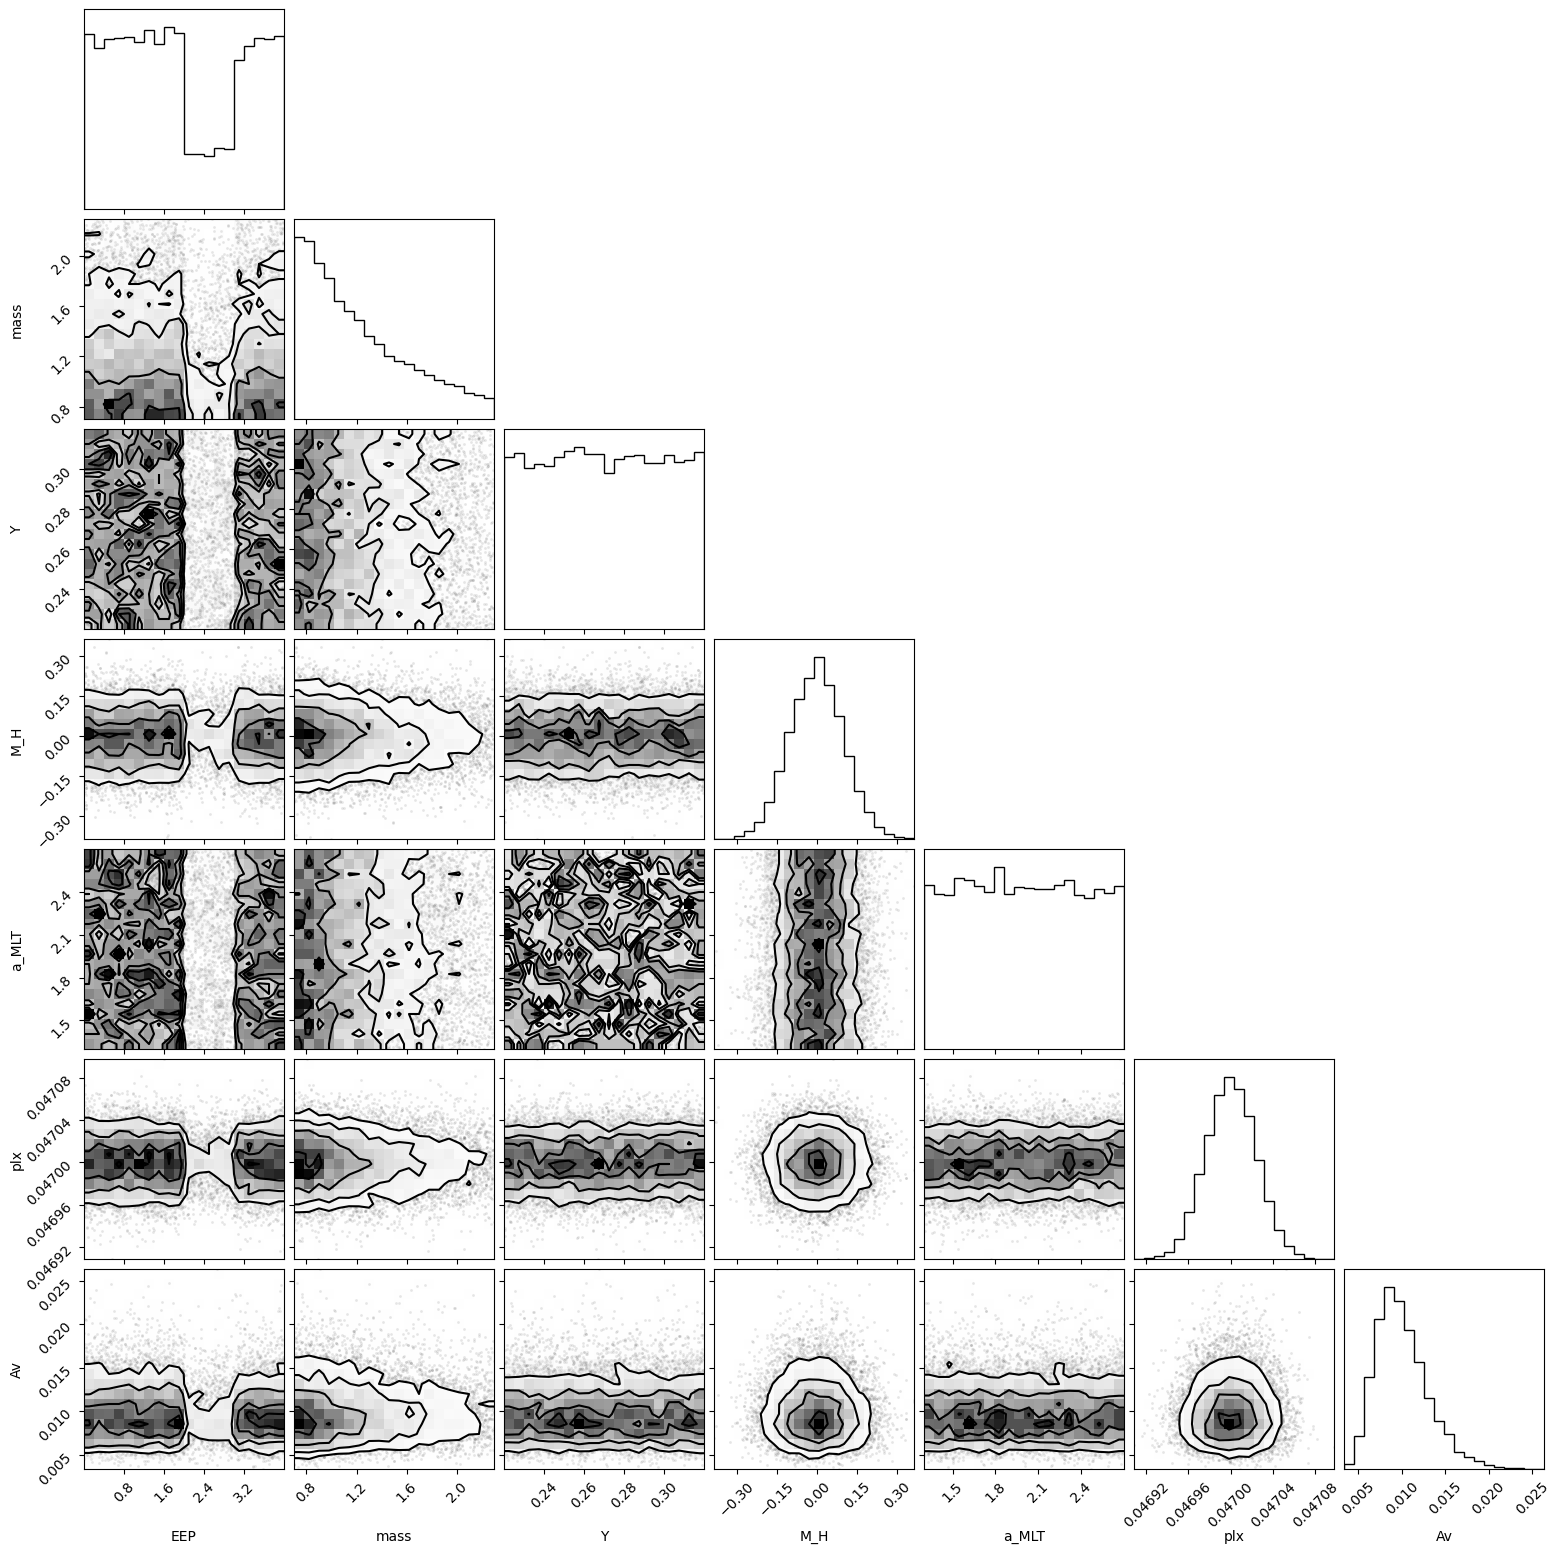

In [10]:
fig = corner(data, group="prior", var_names=["EEP", "mass", "Y", "M_H", "a_MLT", "plx", "Av"])

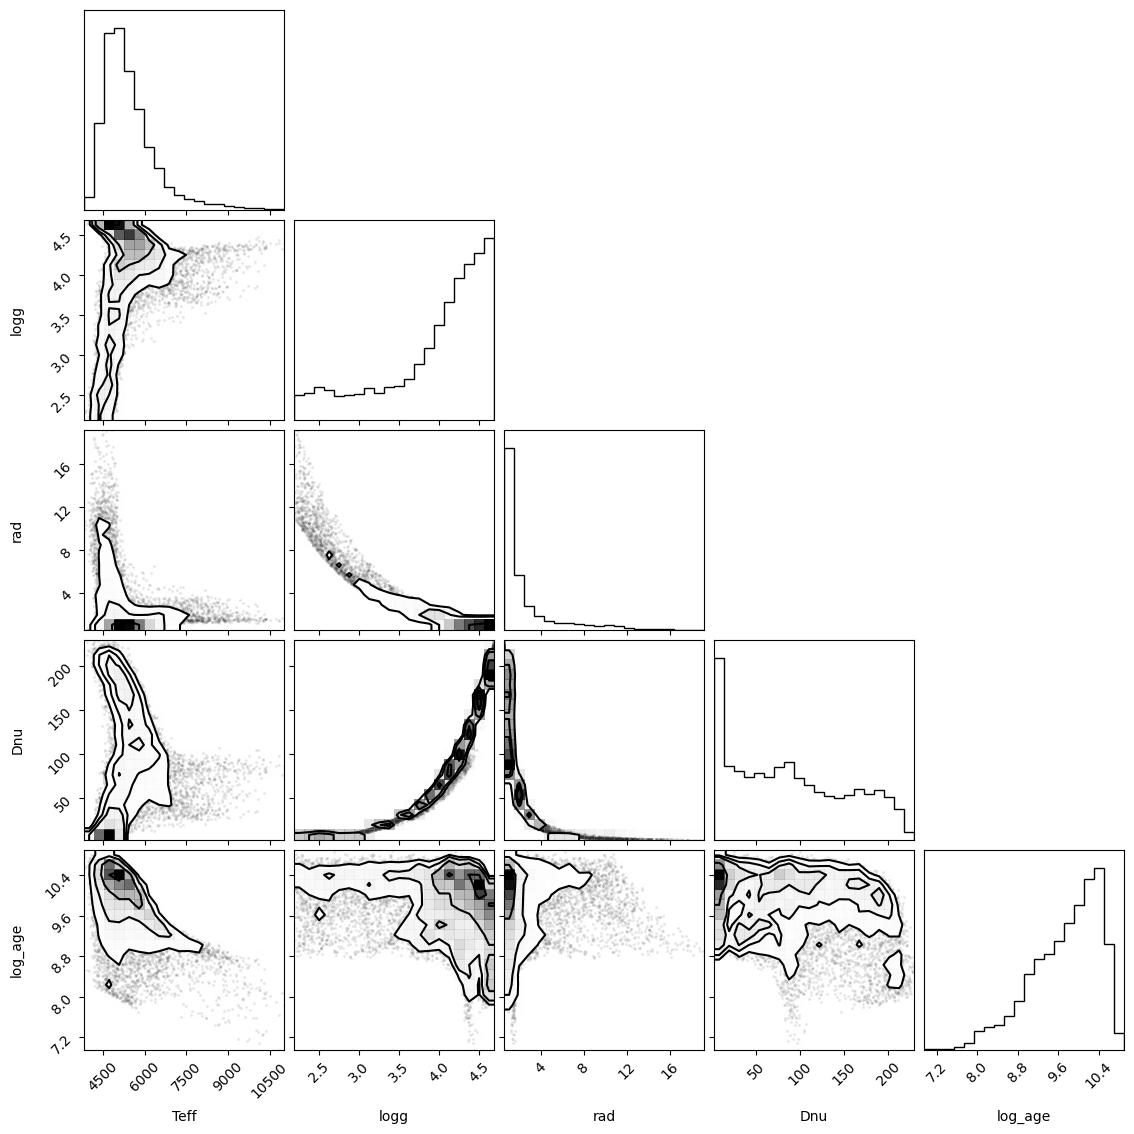

In [9]:
fig = corner(data, group="prior", var_names=["Teff", "logg", "rad", "Dnu", "log_age"])

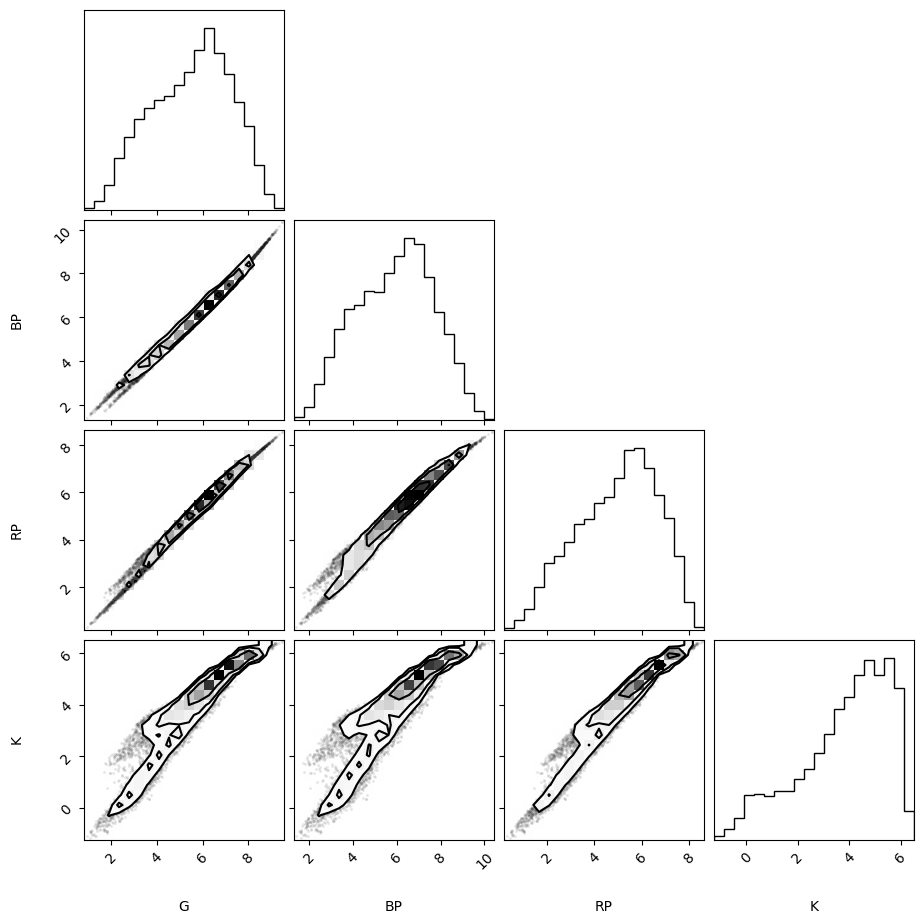

In [10]:
fig = corner(data, group="prior", var_names=model.bands)

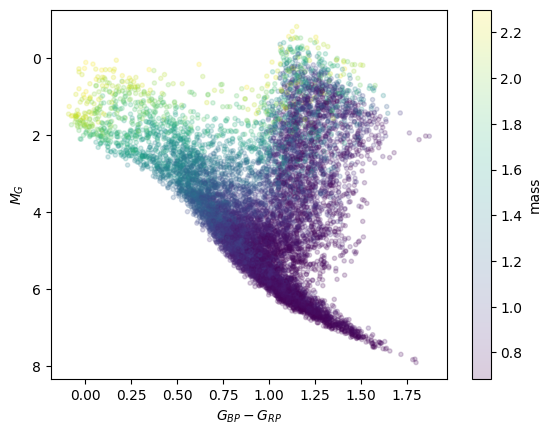

In [11]:
fig, ax = plt.subplots()
ckey = "mass"

s = ax.scatter(prior_samples["BP"]-prior_samples["RP"], prior_samples["G_abs"], 
               c=prior_samples[ckey], marker=".", alpha=0.2)
ax.invert_yaxis()
ax.set_xlabel("$G_{BP} - G_{RP}$")
ax.set_ylabel("$M_G$")
fig.colorbar(s, label=ckey)

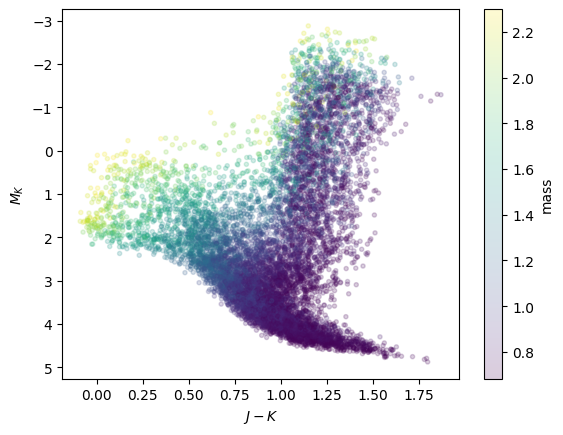

In [12]:
fig, ax = plt.subplots()
ckey = "mass"

s = ax.scatter(prior_samples["BP"]-prior_samples["RP"], prior_samples["K_abs"], 
               c=prior_samples[ckey], marker=".", alpha=0.2)
ax.invert_yaxis()
ax.set_xlabel("$J - K$")
ax.set_ylabel("$M_K$")
fig.colorbar(s, label=ckey)

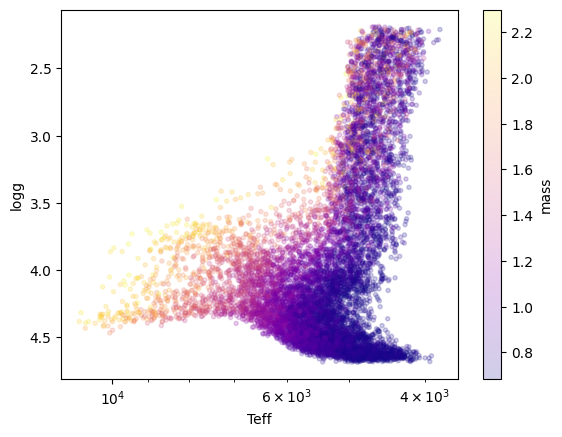

In [13]:
fig, ax = plt.subplots()
xkey = "Teff"
ykey = "logg"
ckey = "mass"
cmap = "plasma"

s = ax.scatter(prior_samples[xkey], prior_samples[ykey], 
           c=prior_samples[ckey], cmap=cmap, marker=".", alpha=0.2)
# ax.set_yscale("log")
ax.set_xscale("log")
ax.invert_xaxis()
ax.invert_yaxis()

ax.set_xlabel(xkey)
ax.set_ylabel(ykey)
fig.colorbar(s, label=ckey)

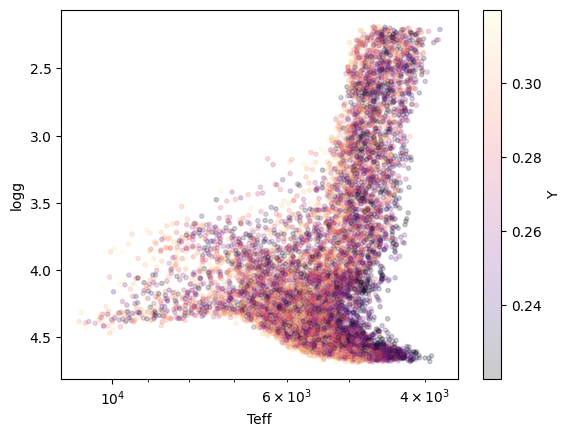

In [14]:
fig, ax = plt.subplots()
xkey = "Teff"
ykey = "logg"
ckey = "Y"
cmap = "magma"

s = ax.scatter(prior_samples[xkey], prior_samples[ykey], 
           c=prior_samples[ckey], cmap=cmap, marker=".", alpha=0.2)
# ax.set_yscale("log")
ax.set_xscale("log")
ax.invert_xaxis()
ax.invert_yaxis()

ax.set_xlabel(xkey)
ax.set_ylabel(ykey)
fig.colorbar(s, label=ckey)

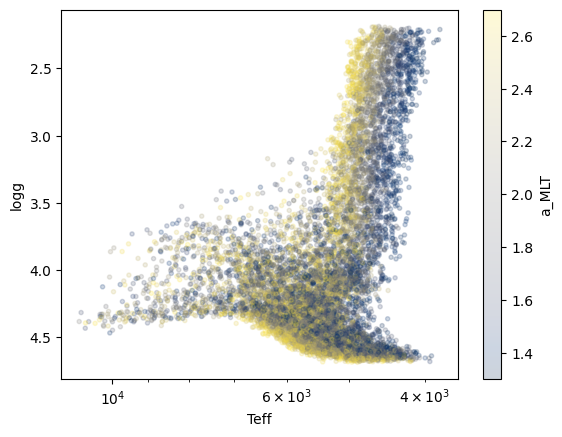

In [15]:
fig, ax = plt.subplots()
xkey = "Teff"
ykey = "logg"
ckey = "a_MLT"
cmap = "cividis"

s = ax.scatter(prior_samples[xkey], prior_samples[ykey], 
           c=prior_samples[ckey], cmap=cmap, marker=".", alpha=0.2)
# ax.set_yscale("log")
ax.set_xscale("log")
ax.invert_xaxis()
ax.invert_yaxis()

ax.set_xlabel(xkey)
ax.set_ylabel(ykey)
fig.colorbar(s, label=ckey)

In [16]:
nuts = NUTS(model, 
#             init_strategy=numpyro.infer.init_to_median,
            dense_mass=[("Y", "a_MLT")],
            )
mcmc = MCMC(nuts, num_warmup=1000, num_samples=1000, num_chains=10)

It is very important that luminosity uncertainty is reasonable. If too low, struggles to sample. This could be emulator noise.

In [17]:
obs = {band: truths[band] for band in model.bands}
const.update({band: {"sigma": 3e-3} for band in model.bands})

In [18]:
rng, key = random.split(rng)
mcmc.run(
    key, const, obs=obs,
)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [19]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
        Av      0.01      0.00      0.01      0.01      0.01   4926.69      1.00
       M_H      0.01      0.06      0.01     -0.10      0.10   3528.40      1.00
         Y      0.27      0.03      0.27      0.22      0.30   2741.38      1.00
     a_MLT      2.02      0.40      2.03      1.46      2.70   4328.65      1.00
   ln_mass      0.45      0.05      0.45      0.35      0.53    382.63      1.02
       plx      0.05      0.00      0.05      0.05      0.05  10219.32      1.00
         x      0.47      0.08      0.47      0.37      0.60    249.90      1.03

Number of divergences: 0


In [20]:
data += az.from_numpyro(mcmc)
data

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> prior
	> observed_data

In [21]:
rng, key = random.split(rng)
post_predictive = Predictive(model, posterior_samples=mcmc.get_samples())
post_samples = post_predictive(key, const, obs=obs)

In [22]:
data += az.from_numpyro(posterior_predictive=post_samples)
data

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> observed_data

In [23]:
az.summary(data, var_names=["mass", "rad", "age"])

/home/alex/miniconda3/envs/numpyro/lib/python3.10/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


mean            sd        hdi_3%       hdi_97%     mcse_mean  \
mass  1.572000e+00  7.500000e-02  1.421000e+00  1.723000e+00  4.000000e-03   
rad   2.385000e+00  6.000000e-03  2.374000e+00  2.396000e+00  0.000000e+00   
age   1.876882e+09  2.515204e+08  1.483803e+09  2.266347e+09  1.271187e+07   

          mcse_sd  ess_bulk  ess_tail  r_hat  
mass        0.003     419.0    1219.0   1.02  
rad         0.000    6584.0    6712.0   1.00  
age   8995358.056     474.0    3059.0   1.02

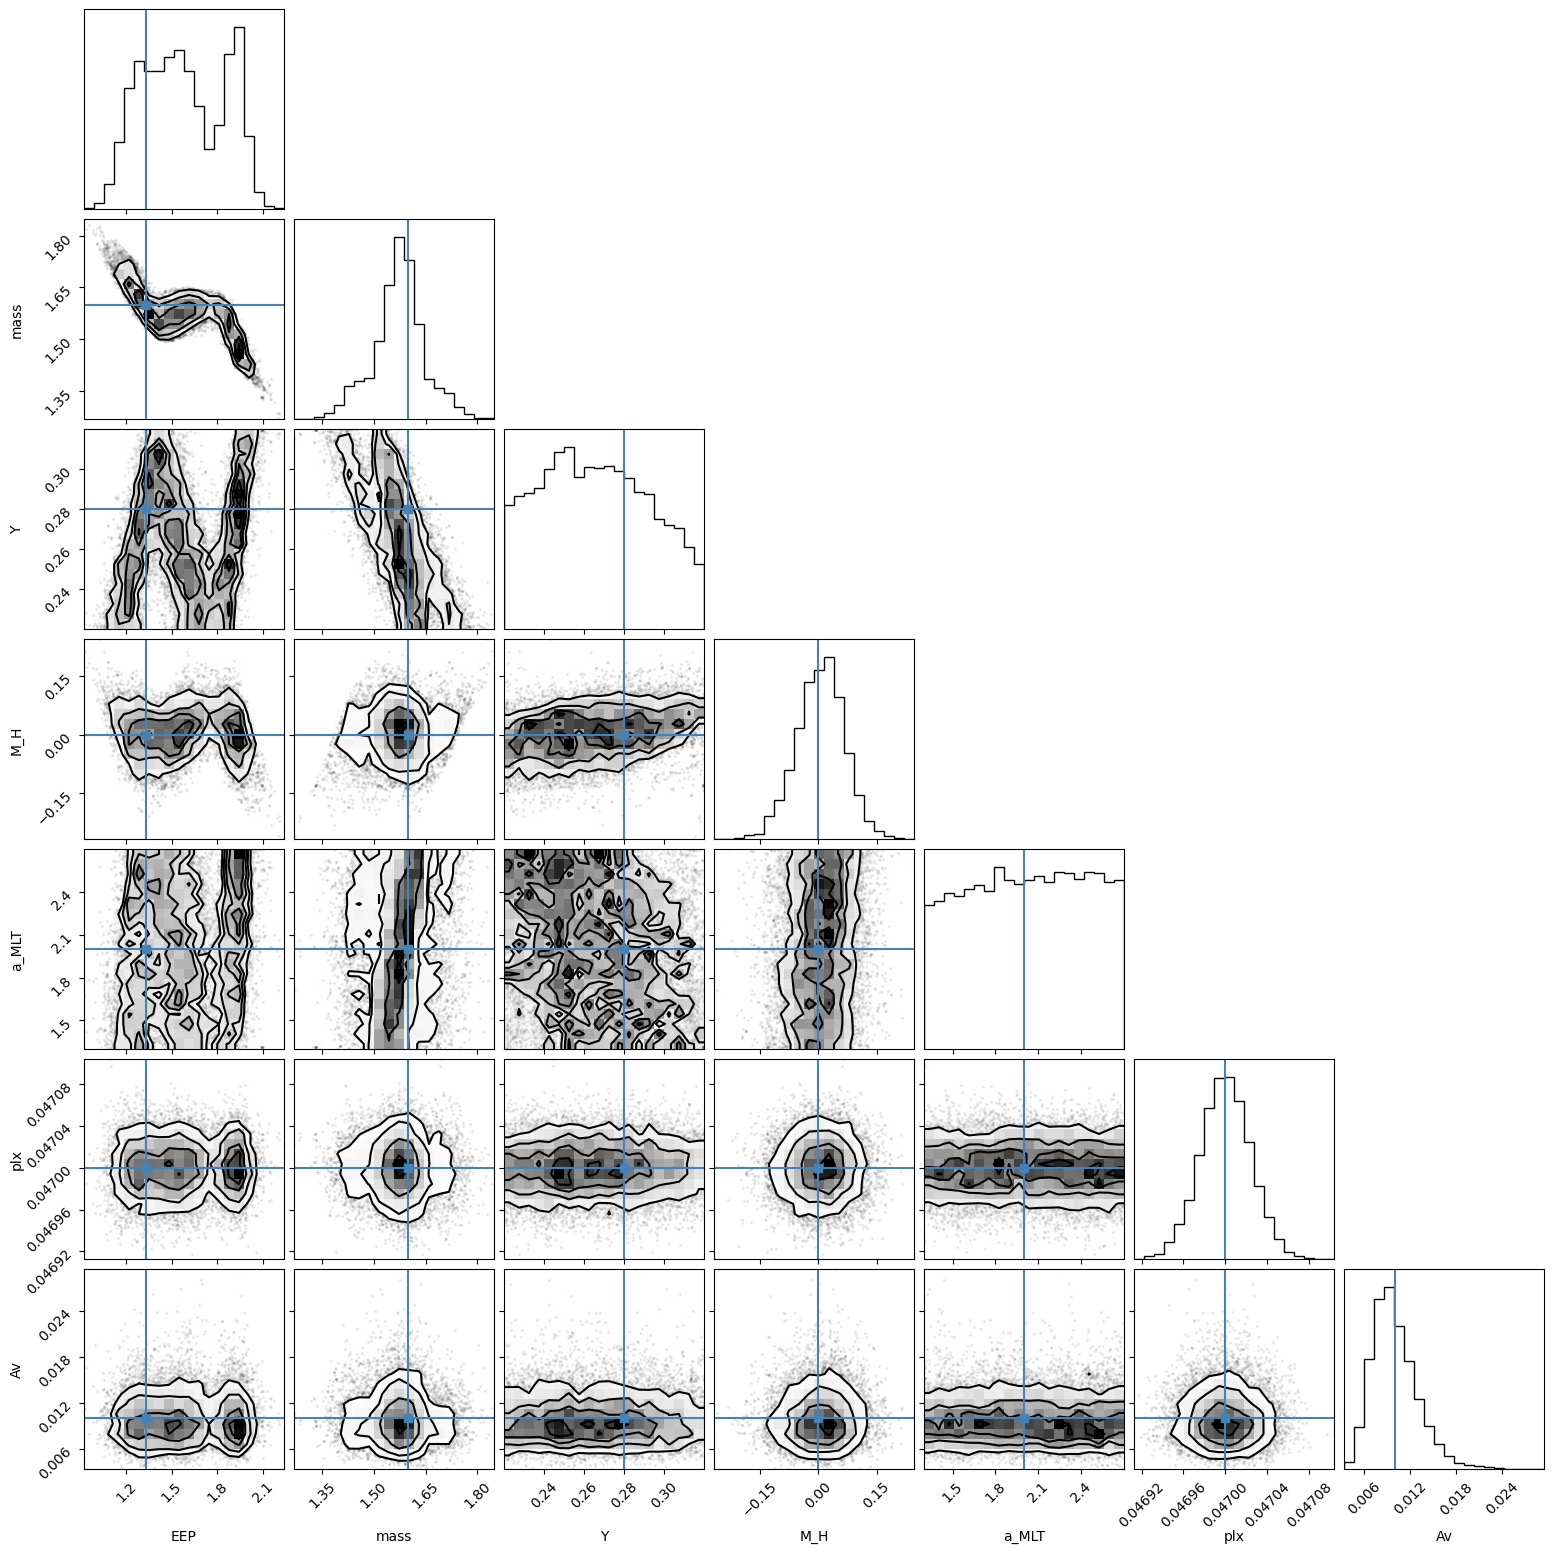

In [24]:
var_names = [
    "EEP", 
    "mass", 
    "Y", 
    "M_H", 
    "a_MLT",
    "plx",
    "Av",
]

fig = corner(
    data, 
    var_names=var_names, 
    divergences=True,
    truths=truths
)

In [25]:
az.summary(data, var_names=["mass", "rad", "age", "Dnu"])

mean            sd        hdi_3%       hdi_97%     mcse_mean  \
mass  1.572000e+00  7.500000e-02  1.421000e+00  1.723000e+00  4.000000e-03   
rad   2.385000e+00  6.000000e-03  2.374000e+00  2.396000e+00  0.000000e+00   
age   1.876882e+09  2.515204e+08  1.483803e+09  2.266347e+09  1.271187e+07   
Dnu   4.414200e+01  1.161000e+00  4.188700e+01  4.643700e+01  4.900000e-02   

          mcse_sd  ess_bulk  ess_tail  r_hat  
mass        0.003     419.0    1219.0   1.02  
rad         0.000    6584.0    6712.0   1.00  
age   8995358.056     474.0    3059.0   1.02  
Dnu         0.035     580.0    1327.0   1.01

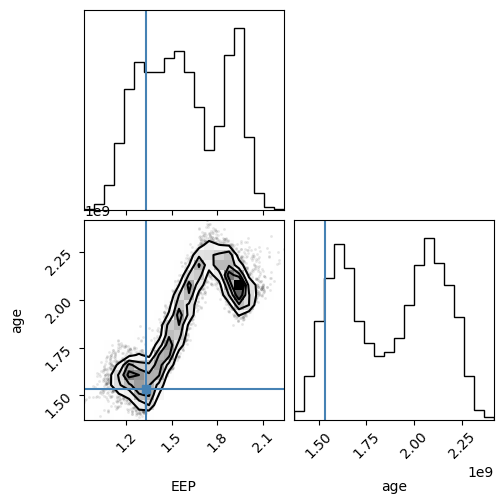

In [34]:
fig = corner(data, var_names=["EEP", "age"], truths=truths)

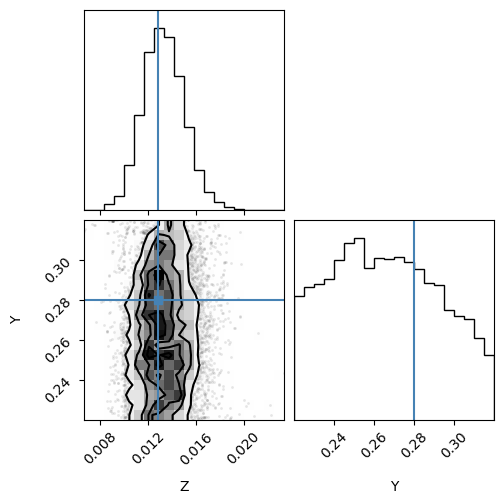

In [215]:
fig = corner(data, var_names=["Z", "Y"], truths=truths)

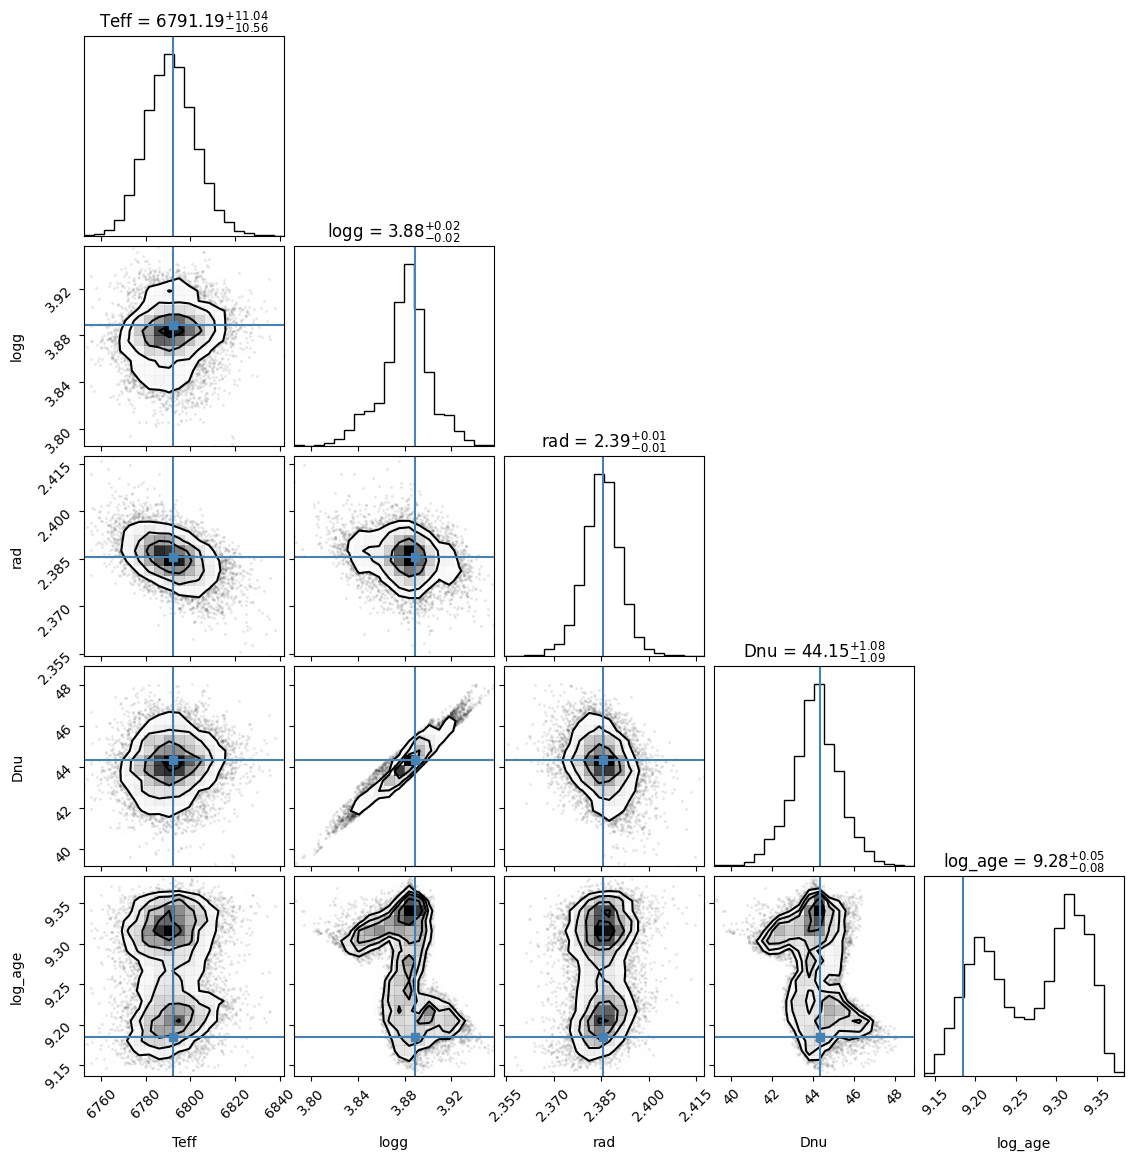

In [28]:
fig = corner(data, var_names=["Teff", "logg", "rad", "Dnu", "log_age"], show_titles=True, truths=truths)

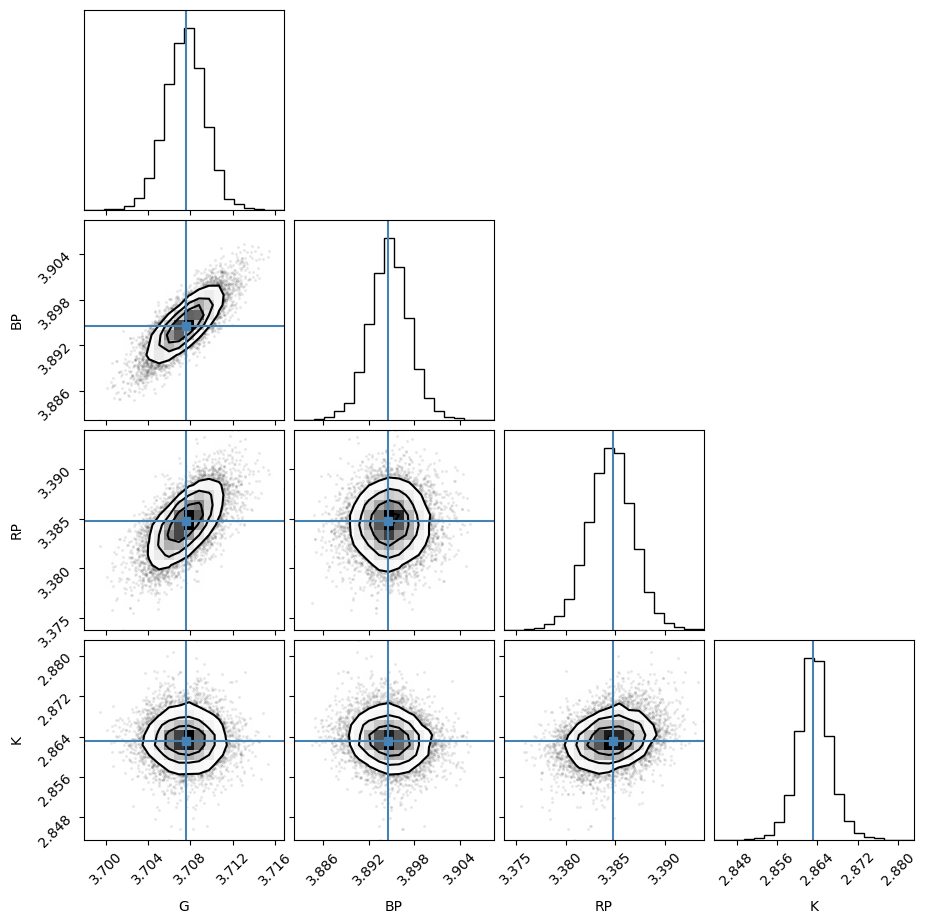

In [29]:
fig = corner(data, var_names=model.bands, truths=truths)

It would be fun to plot stellar tracks to show the overlap going on in the main sequence hook.

In [103]:
from warnings import warn
input_cols = ["EEP", "mass", "Y", "log_Z", "a_MLT"]
output_cols = ["log_age", "log_Teff", "log_rad", "log_Dnu"]

def make_grid(**inputs):
    xi = [np.atleast_1d(inputs.pop(i)) for i in input_cols]
    if len(inputs) > 0:
        warn(f"Unknown keyword arguments have been ignored: {', '.join(inputs.keys())}.")
    coords = np.stack(np.meshgrid(*xi, indexing='ij'), axis=-1)
    X = np.reshape(coords, (np.prod(coords.shape[:-1]), coords.shape[-1]))
    index = pd.MultiIndex.from_arrays(X.T, names=input_cols)
    y = model.emulator(X)
    return pd.DataFrame(y, index=index, columns=output_cols)

In [189]:
EEP = np.linspace(*data.posterior.EEP.quantile([.1, .9]), 101)
mass = np.linspace(*data.posterior.mass.quantile([.1, .9]), 20)
grid = make_grid(
    EEP=EEP, 
    mass=mass,
    Y=data.posterior.Y.mean(),
    log_Z=np.log10(data.posterior.Z).mean(),
    a_MLT=data.posterior.a_MLT.mean(),
)
grid.head()

log_age  log_Teff   log_rad  \
EEP      mass     Y        log_Z     a_MLT                                    
1.233152 1.469020 0.266107 -1.879734 2.018234  9.285620  3.820735  0.298708   
         1.479203 0.266107 -1.879734 2.018234  9.277910  3.821648  0.302963   
         1.489387 0.266107 -1.879734 2.018234  9.270093  3.822589  0.307240   
         1.499570 0.266107 -1.879734 2.018234  9.262337  3.823579  0.311518   
         1.509753 0.266107 -1.879734 2.018234  9.254861  3.824644  0.315784   

                                                log_Dnu  
EEP      mass     Y        log_Z     a_MLT               
1.233152 1.469020 0.266107 -1.879734 2.018234  1.755580  
         1.479203 0.266107 -1.879734 2.018234  1.749743  
         1.489387 0.266107 -1.879734 2.018234  1.743895  
         1.499570 0.266107 -1.879734 2.018234  1.737973  
         1.509753 0.266107 -1.879734 2.018234  1.731976

In [190]:
mass = grid.index.get_level_values("mass")
grid["logg"] = model.log_gravity(np.log10(mass), grid["log_rad"])

In [191]:
from matplotlib.collections import LineCollection
from matplotlib.colors import BoundaryNorm, ListedColormap
import matplotlib.patches as mpatches

Text(0.5, 1.0, '$T_\\mathrm{eff}$ = 6791 ± 11 K, log(g) = 3.88 ± 0.02')

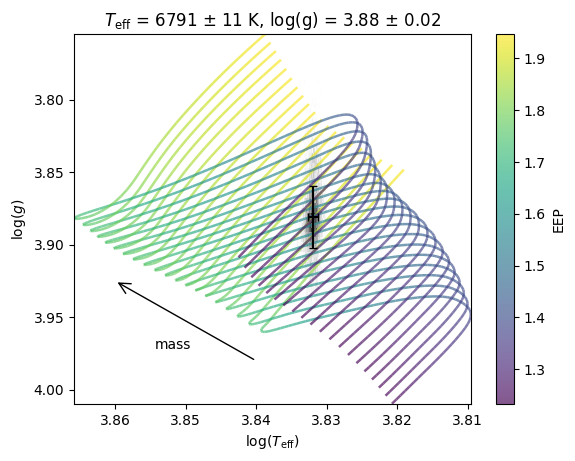

In [225]:
fig, ax = plt.subplots()

norm = plt.Normalize(EEP[0], EEP[-1])

for name, group in grid.groupby("mass"):
    points = np.array([group["log_Teff"], group["logg"]]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    lc = LineCollection(segments, cmap='viridis', norm=norm, alpha=0.66)
    lc.set_array(EEP)
    lc.set_linewidth(1.8)
    line = ax.add_collection(lc)

fig.colorbar(line, ax=ax, label="EEP")

ax.hist2d(np.log10(post_samples["Teff"]), post_samples["logg"], bins=50, cmap="gray_r")
mean = post_samples["Teff"].mean(), np.log10(post_samples["Teff"]).mean(), post_samples["logg"].mean()
std = post_samples["Teff"].std(), np.log10(post_samples["Teff"]).std(), post_samples["logg"].std()

ax.errorbar(
    *mean[1:], xerr=std[1], yerr=std[2],
    fmt="k", capsize=3,
)

arr = mpatches.FancyArrowPatch((3.84, 3.98), (3.86, 3.925),
                               arrowstyle='->', mutation_scale=20)
ax.add_patch(arr)
ax.annotate("mass", (.4, .1), xycoords=arr, ha='center', va='bottom')

ax.set_xlim(grid["log_Teff"].min(), grid["log_Teff"].max())
ax.set_ylim(grid["logg"].min(), grid["logg"].max())

ax.invert_xaxis()
ax.invert_yaxis()

ax.set_xlabel("$\log(T_\\mathrm{eff})$")
ax.set_ylabel("$\log(g)$")

ax.set_title(f"$T_\\mathrm{{eff}}$ = {mean[0]:.0f} ± {std[0]:.0f} K, log(g) = {mean[2]:.2f} ± {std[2]:.2f}")

In [220]:
truths

{'x': 0.4,
 'ln_mass': 0.47000362924573563,
 'Y': 0.28,
 'M_H': 0.0,
 'a_MLT': 2.0,
 'plx': 0.047,
 'Av': 0.01,
 'EEP': Array(1.33333333, dtype=float64),
 'mass': Array(1.6, dtype=float64),
 'Z': 0.012800314310971419,
 'log_lum': Array(1.03791676, dtype=float64),
 'log_rad': Array(0.3775951, dtype=float64),
 'rad': Array(2.38558613, dtype=float64),
 'logg': Array(3.88892978, dtype=float64),
 'lum': Array(10.91231169, dtype=float64),
 'Teff': Array(6792.16084876, dtype=float64),
 'Dnu': Array(44.34620734, dtype=float64),
 'log_age': Array(9.18513683, dtype=float64),
 'age': Array(1.53156993e+09, dtype=float64),
 'dist': 21.27659574468085,
 'G_abs': Array(2.06806547, dtype=float64),
 'G': Array(3.70757618, dtype=float64),
 'BP_abs': Array(2.25506435, dtype=float64),
 'BP': Array(3.89457506, dtype=float64),
 'RP_abs': Array(1.74521531, dtype=float64),
 'RP': Array(3.38472602, dtype=float64),
 'K_abs': Array(1.22367522, dtype=float64),
 'K': Array(2.86318593, dtype=float64)}